In [1]:
import numpy as np
import math
import torch
import torchvision.transforms as T
from decord import VideoReader, cpu
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer


/home/dguillory/anaconda3/envs/internvl/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/home/dguillory/anaconda3/envs/internvl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform
    

In [3]:
def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

In [4]:
def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

In [5]:
def load_image(image_file, input_size=448, max_num=12):
    image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values


In [50]:
from PIL import Image
import requests
from io import BytesIO

def load_image_from_url(image_url, input_size=448, max_num=12):
    headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)"}
    
    response = requests.get(image_url, headers=headers)
    #print(response.content)
    image = Image.open(BytesIO(response.content)).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

In [6]:
def split_model(model_name):
    device_map = {}
    world_size = torch.cuda.device_count()
    num_layers = {
        'InternVL2_5-1B': 24, 'InternVL2_5-2B': 24, 'InternVL2_5-4B': 36, 'InternVL2_5-8B': 32,
        'InternVL2_5-26B': 48, 'InternVL2_5-38B': 64, 'InternVL2_5-78B': 80}[model_name]
    # Since the first GPU will be used for ViT, treat it as half a GPU.
    num_layers_per_gpu = math.ceil(num_layers / (world_size - 0.5))
    num_layers_per_gpu = [num_layers_per_gpu] * world_size
    num_layers_per_gpu[0] = math.ceil(num_layers_per_gpu[0] * 0.5)
    layer_cnt = 0
    for i, num_layer in enumerate(num_layers_per_gpu):
        for j in range(num_layer):
            device_map[f'language_model.model.layers.{layer_cnt}'] = i
            layer_cnt += 1
    device_map['vision_model'] = 0
    device_map['mlp1'] = 0
    device_map['language_model.model.tok_embeddings'] = 0
    device_map['language_model.model.embed_tokens'] = 0
    device_map['language_model.model.rotary_emb'] = 0
    device_map['language_model.output'] = 0
    device_map['language_model.model.norm'] = 0
    device_map['language_model.lm_head'] = 0
    device_map[f'language_model.model.layers.{num_layers - 1}'] = 0

    return device_map

In [7]:
world_size = torch.cuda.device_count()
print(world_size)

6


In [8]:
# If you have an 80G A100 GPU, you can put the entire model on a single GPU.
# Otherwise, you need to load a model using multiple GPUs, please refer to the `Multiple GPUs` section.


path = 'OpenGVLab/InternVL2_5-8B'
device_map = split_model('InternVL2_5-8B')

model = AutoModel.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    use_flash_attn=True,
    trust_remote_code=True,
    device_map=device_map).eval()
"""
model = AutoModel.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    trust_remote_code=True,
    device_map=device_map).eval().cuda()
"""


tokenizer = AutoTokenizer.from_pretrained(path, trust_remote_code=True, use_fast=False)


/home/dguillory/anaconda3/envs/internvl/lib/python3.9/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|████████████████████████████████████| 4/4 [00:05<00:00,  1.45s/it]
/home/dguillory/anaconda3/envs/internvl/lib/python3.9/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/dguillory/anaconda3/envs/internvl/lib/python3.9/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_d

In [9]:
print(device_map)

{'language_model.model.layers.0': 0, 'language_model.model.layers.1': 0, 'language_model.model.layers.2': 0, 'language_model.model.layers.3': 1, 'language_model.model.layers.4': 1, 'language_model.model.layers.5': 1, 'language_model.model.layers.6': 1, 'language_model.model.layers.7': 1, 'language_model.model.layers.8': 1, 'language_model.model.layers.9': 2, 'language_model.model.layers.10': 2, 'language_model.model.layers.11': 2, 'language_model.model.layers.12': 2, 'language_model.model.layers.13': 2, 'language_model.model.layers.14': 2, 'language_model.model.layers.15': 3, 'language_model.model.layers.16': 3, 'language_model.model.layers.17': 3, 'language_model.model.layers.18': 3, 'language_model.model.layers.19': 3, 'language_model.model.layers.20': 3, 'language_model.model.layers.21': 4, 'language_model.model.layers.22': 4, 'language_model.model.layers.23': 4, 'language_model.model.layers.24': 4, 'language_model.model.layers.25': 4, 'language_model.model.layers.26': 4, 'language_

In [13]:
# set the max number of tiles in `max_num`
pixel_values = load_image('./examples/fighter_jets.jpg', max_num=12).to(torch.bfloat16).cuda()
generation_config = dict(max_new_tokens=1024, do_sample=False)




In [14]:
# pure-text conversation (纯文本对话)
question = 'Hello, who are you?'
response, history = model.chat(tokenizer, None, question, generation_config, history=None, return_history=True)
print(f'User: {question}\nAssistant: {response}')

User: Hello, who are you?
Assistant: Hello! I am an AI assistant whose name is InternVL, developed jointly by Shanghai AI Lab, Tsinghua University and other partners.


In [15]:
question = 'Can you tell me a story?'
response, history = model.chat(tokenizer, None, question, generation_config, history=history, return_history=True)
print(f'User: {question}\nAssistant: {response}')



User: Can you tell me a story?
Assistant: Of course! Here's a story for you:

Once upon a time, in a small village nestled in the heart of a dense forest, there lived a young girl named Elara. Elara was known throughout the village for her kind heart and her love for nature. She spent most of her days exploring the forest, discovering new plants, and learning about the animals that lived there.

One day, while wandering deeper into the forest than she had ever been before, Elara stumbled upon a hidden clearing. In the center of the clearing stood an enormous tree, its branches reaching up to the sky. As she approached the tree, she noticed that it was unlike any other tree she had ever seen. Its bark was a deep, rich brown, and its leaves shimmered in the sunlight.

Suddenly, a soft voice spoke to her from within the tree. "Welcome, Elara," it said. "I have been waiting for you. My name is Oakley, and I am the guardian of this forest."

Elara was amazed. She had never heard of a talkin

In [16]:
# single-image single-round conversation (单图单轮对话)
question = '<image>\nPlease describe the image shortly.'
response = model.chat(tokenizer, pixel_values, question, generation_config)
print(f'User: {question}\nAssistant: {response}')

User: <image>
Please describe the image shortly.
Assistant: The image is an aerial view of a city with a large stadium near a river. There are highways, bridges, and a mix of residential and industrial areas. The landscape includes green spaces and a clear blue sky.


In [17]:
# single-image multi-round conversation (单图多轮对话)
question = '<image>\nPlease describe the image in detail.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config, history=None, return_history=True)
print(f'User: {question}\nAssistant: {response}')

User: <image>
Please describe the image in detail.
Assistant: The image is an aerial view of a cityscape featuring a large stadium prominently situated near a river. The stadium has a distinctive circular design with a white roof and is surrounded by a network of roads and highways. The river flows through the city, with a bridge crossing over it. The surrounding area includes a mix of residential and commercial buildings, with some green spaces and open fields visible. The city extends into the distance, with a clear sky overhead. The layout suggests a well-developed urban area with significant infrastructure.


In [18]:
question = 'Please write a poem according to the image.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config, history=history, return_history=True)
print(f'User: {question}\nAssistant: {response}')


User: Please write a poem according to the image.
Assistant: In the heart of the city, where rivers gently flow,
A stadium stands proud, a beacon of show.
Circular in design, with a roof so white,
It draws crowds near, a place of delight.

Bridges arch gracefully, over waters so blue,
Connecting paths, for all to pursue.
Buildings rise high, in a tapestry of life,
A city alive, with stories to rife.

Green spaces whisper, amidst concrete and steel,
Nature's embrace, a sight to reveal.
The sky above, a canvas so clear,
A cityscape, where dreams are near.

In this urban sprawl, where life moves so fast,
Moments of peace, in nature's vast.
A place where dreams take flight, and memories are made,
In the city's embrace, where the future is played.


In [19]:
pixel_values1 = load_image('./examples/cat_image.jpg', max_num=12).to(torch.bfloat16).cuda()
pixel_values2 = load_image('./examples/fighter_jets.jpg', max_num=12).to(torch.bfloat16).cuda()
pixel_values = torch.cat((pixel_values1, pixel_values2), dim=0)

In [20]:
question = '<image>\nDescribe the two images in detail.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config,
                               history=None, return_history=True)
print(f'User: {question}\nAssistant: {response}')

User: <image>
Describe the two images in detail.
Assistant: The first image shows a quaint, two-story house with a wrap-around porch. The house is painted white and features a gabled roof with dormer windows. The porch is supported by columns and has a railing. A concrete pathway leads up to the porch, and the house is surrounded by a grassy yard with some small plants and trees. A street lamp is visible in the foreground.

The second image is an aerial view of a cityscape. It shows a large stadium surrounded by roads and highways. A river runs through the city, with bridges crossing over it. The city is densely packed with buildings, and there are patches of greenery interspersed throughout. The horizon shows a clear blue sky, and the overall layout suggests a well-developed urban area.


In [21]:
question = 'What are the similarities and differences between these two images.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config,
                               history=history, return_history=True)
print(f'User: {question}\nAssistant: {response}')

User: What are the similarities and differences between these two images.
Assistant: **Similarities:**

1. **Architectural Focus:** Both images feature buildings as the main subject. The first image shows a residential house, while the second shows a large stadium and surrounding urban structures.

2. **Surrounding Environment:** Both images include elements of nature. The first image has grassy areas and trees, while the second shows a river and patches of greenery within the city.

3. **Perspective:** The first image is a ground-level view, while the second is an aerial view, providing a bird's-eye perspective of the city.

**Differences:**

1. **Type of Building:** The first image depicts a residential house, while the second shows a large public stadium and urban infrastructure.

2. **Scale:** The first image is of a small, intimate setting, while the second image captures a vast, expansive urban area.

3. **Purpose:** The first image conveys a sense of home and tranquility, while 

In [22]:
pixel_values1 = load_image('./examples/cat_image.jpg', max_num=12).to(torch.bfloat16).cuda()
pixel_values2 = load_image('./examples/fighter_jets.jpg', max_num=12).to(torch.bfloat16).cuda()
pixel_values = torch.cat((pixel_values1, pixel_values2), dim=0)
num_patches_list = [pixel_values1.size(0), pixel_values2.size(0)]

In [23]:
question = 'Image-1: <image>\nImage-2: <image>\nDescribe the two images in detail.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config,
                               num_patches_list=num_patches_list,
                               history=None, return_history=True)
print(f'User: {question}\nAssistant: {response}')


User: Image-1: <image>
Image-2: <image>
Describe the two images in detail.
Assistant: Image-1: The image depicts a two-story white house with a gray shingled roof, situated in a lush, green environment. The house features a wrap-around porch with white railings and columns, and a set of stairs leading up to the main entrance. The front yard is adorned with a variety of plants and flowers, including yellow daffodils. A concrete pathway leads to the house, flanked by grass and a few small shrubs. A black street lamp stands prominently in the foreground on the right side of the image. The surrounding area is filled with trees, suggesting a serene, suburban setting.

Image-2: The image is an aerial view of a cityscape featuring a large stadium surrounded by a network of roads and highways. A river flows through the scene, with a bridge crossing it. The city is densely populated with numerous buildings, and there are patches of greenery interspersed throughout the urban area. The sky is cle

In [24]:
question = 'What are the similarities and differences between these two images.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config,
                               num_patches_list=num_patches_list,
                               history=history, return_history=True)
print(f'User: {question}\nAssistant: {response}')

User: What are the similarities and differences between these two images.
Assistant: The two images depict very different scenes. The first image shows a house in a natural setting, while the second image shows a cityscape with a stadium and a river. The first image is more serene and peaceful, while the second image is more bustling and urban. The first image has a focus on nature and architecture, while the second image has a focus on urban planning and infrastructure. The first image is more static, while the second image is more dynamic. The first image is more intimate, while the second image is more expansive. The first image is more personal, while the second image is more public. The first image is more private, while the second image is more public. The first image is more personal, while the second image is more public. The first image is more private, while the second image is more public. The first image is more personal, while the second image is more public. The first ima

In [34]:
pixel_values = load_image('./examples/fighter_jets.jpg', max_num=12).to(torch.bfloat16).cuda()
generation_config = dict(max_new_tokens=1024, do_sample=False)


In [40]:
question = '<image>\nPlease count how many fighter jets are in the image. Also describe where they are located and how they look.'
response = model.chat(tokenizer, pixel_values, question, generation_config)
print(f'User: {question}\nAssistant: {response}')

User: <image>
Please count how many fighter jets are in the image. Also describe where they are located and how they look.
Assistant: There are three fighter jets visible in the image. They are located in the middle section, near the large stadium. The jets are arranged in a triangular formation, with one at the top and two at the bottom. They appear to be stationary and are positioned on a flat, open area.


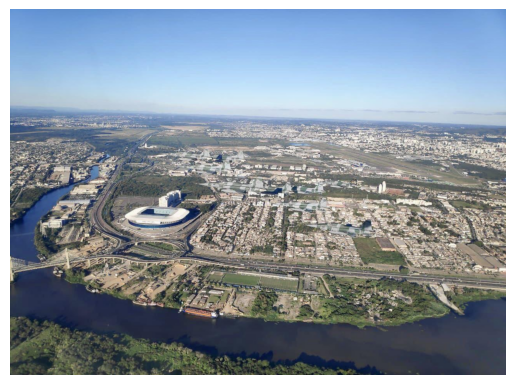

In [38]:
import matplotlib.pyplot as plt
from PIL import Image

# Load image
img = Image.open("./examples/fighter_jets.jpg")

# Show image
plt.imshow(img)
plt.axis("off")   # hide axes
plt.show()

In [51]:
pixel_values = load_image_from_url('https://image.cnbcfm.com/api/v1/image/107196244-1676618256129-An_Li.jpg?v=1676635561&w=1260&h=709&ffmt=webp&vtcrop=y', max_num=12).to(torch.bfloat16).cuda()


In [52]:
def prompt_from_url(image_url, question="Please describe the image in as much detail as possible"):
    question = '<image>\n'+ question

    headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)"}
    
    response = requests.get(image_url, headers=headers)
    #print(response.content)
    img = Image.open(BytesIO(response.content))

    pixel_values = load_image_from_url(image_url, max_num=12).to(torch.bfloat16).cuda()

    response = model.chat(tokenizer, pixel_values, question, generation_config)
    print(f'User: {question}\nAssistant: {response}')

    # Show image
    plt.imshow(img)
    plt.axis("off")   # hide axes
    plt.show()


In [112]:
def prompt_from_path(image_path, question="Please describe the image in as much detail as possible"):
    question = '<image>\n'+ question
    img = Image.open(image_path)

    pixel_values = load_image(image_path, max_num=12).to(torch.bfloat16).cuda()

    response = model.chat(tokenizer, pixel_values, question, generation_config)
    print(f'User: {question}\nAssistant: {response}')

    # Show image
    plt.imshow(img)
    plt.axis("off")   # hide axes
    plt.show()


User: <image>
Please describe the image in as much detail as possible
Assistant: The image is a black and white photograph depicting a vast, terraced landscape, likely a salt flat or salt pans. The terraces are arranged in a grid-like pattern, with each section filled with water, reflecting the sky above. The landscape is surrounded by steep, rugged mountains, creating a dramatic backdrop. 

In the foreground, a person is visible, walking along one of the terraces. The person appears small in comparison to the expansive terrain, emphasizing the scale of the landscape. The sky is overcast, adding to the dramatic and somewhat somber mood of the image. The overall composition highlights the intricate design of the terraces and the natural beauty of the mountainous surroundings.


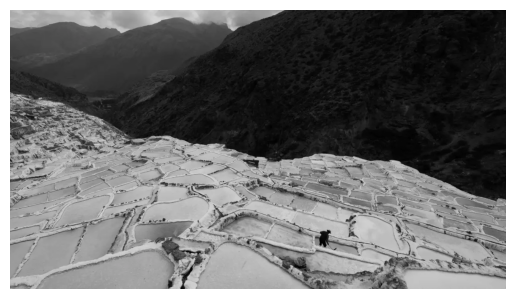

In [53]:
prompt_from_url("https://image.cnbcfm.com/api/v1/image/107196244-1676618256129-An_Li.jpg?v=1676635561&w=1260&h=709&ffmt=webp&vtcrop=y")

User: <image>
which is closer to the camera the eagle or the horse
Assistant: The eagle is closer to the camera.


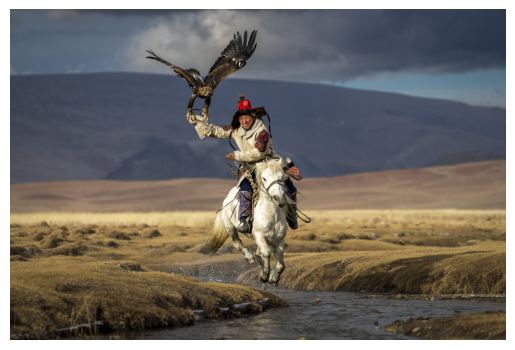

In [107]:
prompt_from_url("https://image.cnbcfm.com/api/v1/image/107196238-1676617601203-Eric_Esterle.jpg?v=1676635561",
               "which is closer to the camera the eagle or the horse")


User: <image>
please only describe the upper left quadrant of this image
Assistant: In the upper left quadrant of the image, there is a muscular individual posing on stage. The person is wearing a purple posing suit and has a number tag on their right hip. The background features a dark, geometric pattern with blue and white accents.


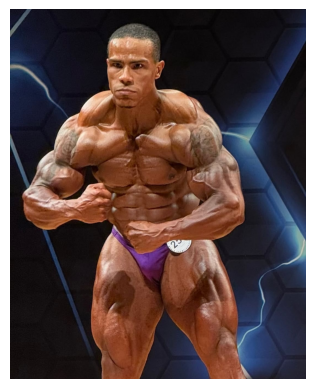

In [106]:
prompt_from_url(
    "https://substackcdn.com/image/fetch/$s_!3hGr!,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F53b40458-0193-4299-a621-82598ae23fce_1080x1350.jpeg",
    "please only describe the upper left quadrant of this image")


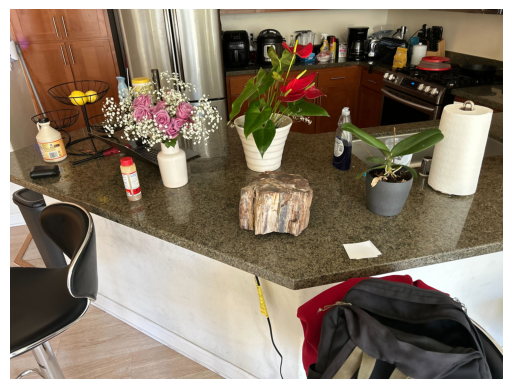

In [111]:
img = Image.open("../../local_datasets/IMG_4407.jpg")
plt.imshow(img)
plt.axis("off")   # hide axes
plt.show()

User: <image>
Please describe the image in as much detail as possible
Assistant: The image shows a kitchen island with a granite countertop. On the countertop, there are several decorative items and kitchen supplies. 

1. **Plants**: 
   - A large potted plant with red flowers and broad green leaves is prominently placed in the center.
   - A smaller potted plant with long, slender leaves is on the right side.

2. **Flowers**: 
   - A vase with a bouquet of pink roses and white baby's breath is on the left side.

3. **Decorative Items**: 
   - A piece of driftwood is placed in the center of the island.
   - A roll of paper towels is on the right side.

4. **Kitchen Supplies**: 
   - A bottle of olive oil is on the left side.
   - A bottle of hot sauce is next to the olive oil.
   - A black knife block is on the left side of the island.
   - A coffee maker and other kitchen appliances are visible in the background.

5. **Fruit Basket**: 
   - A wire fruit basket with two yellow lemons i

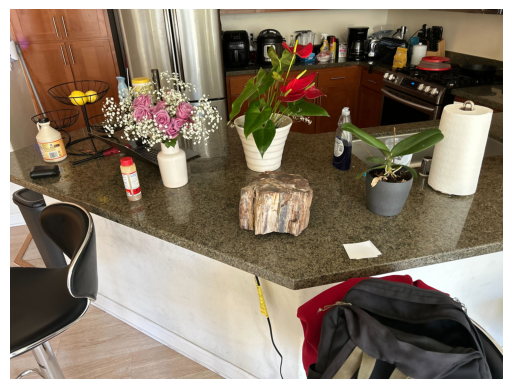

In [113]:
prompt_from_path("../../local_datasets/IMG_4407.jpg")
